In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from scipy import interp
from itertools import cycle

# Data Import

In [53]:
# Load the dataset
dataset = pd.read_csv('ObesityDataSet.csv')

# Display basic information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

# Data Cleaning

In [54]:
# Check for missing values
dataset.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [55]:
# Check for duplicates
dataset.duplicated().sum()

24

In [56]:
# Remove duplicate rows, keeping the first occurrence
dataset = dataset.drop_duplicates()

In [57]:
# First, create a unique mapping of categories to integers
unique_categories = dataset['NObeyesdad'].unique()
category_to_integer = {category: index for index, category in enumerate(unique_categories)}

# Then, apply this mapping to transform all categories into their respective integers
dataset['NObeyesdad'] = dataset['NObeyesdad'].map(category_to_integer)

# Rename the target variable
dataset = dataset.rename(columns = {"NObeyesdad" : "Obesity_level"})

In [59]:
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_level
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,1
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,2


# Exploratory Data Analysis (EDA)

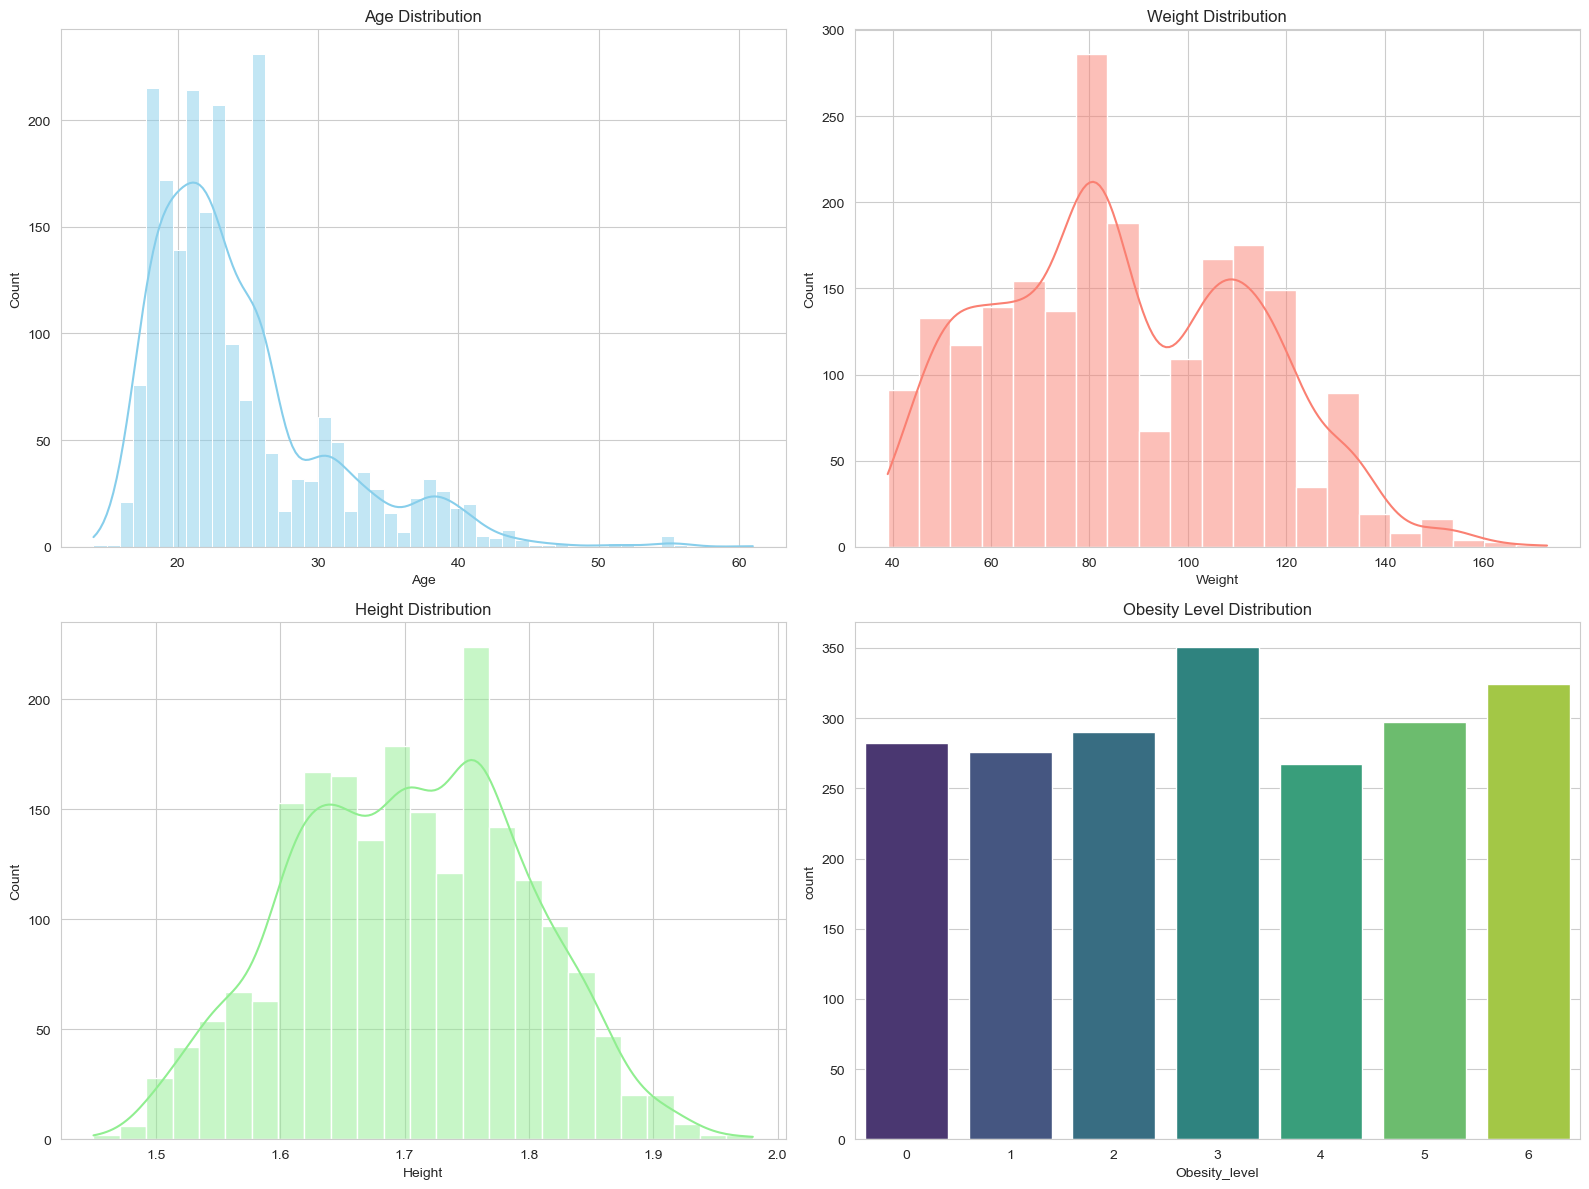

In [7]:
# Setting up the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure to hold the subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of Age
sns.histplot(dataset['Age'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Age Distribution')

# Distribution of Weight
sns.histplot(dataset['Weight'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Weight Distribution')

# Distribution of Height
sns.histplot(dataset['Height'], kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Height Distribution')

# Distribution of Obesity Level
sns.countplot(x='Obesity_level', data=dataset, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Obesity Level Distribution')

plt.tight_layout()
plt.show()

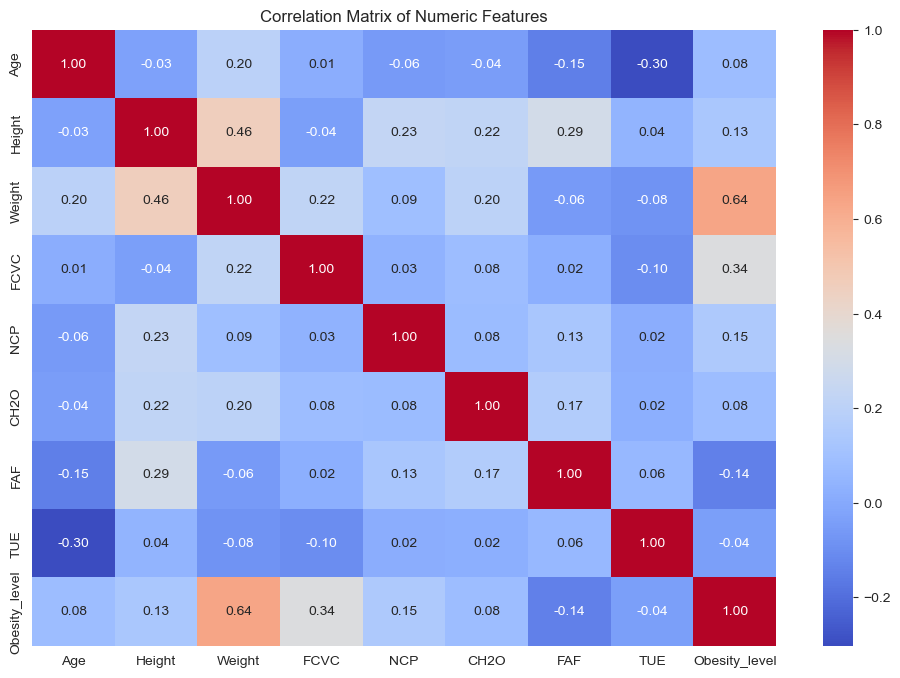

In [8]:
# Calculating the correlation matrix
columns = dataset[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Obesity_level']]
correlation_matrix = columns.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Feature Selection

In [9]:
# Now we perform feature selection using SelectKBest
# Selecting features and the target variable
features = dataset.drop(['Obesity_level'], axis=1)
target = dataset['Obesity_level']
# Converting categorical variables into dummy/indicator variables
features_dummy = pd.get_dummies(features)

# We will select the top 10 features based on the univariate statistical test (ANOVA F-value)
select_k_best = SelectKBest(score_func=f_classif, k=10)
X_best = select_k_best.fit_transform(features_dummy, target)

# Get the indices of selected features
selected_indices = select_k_best.get_support(indices=True)
selected_feature_names = features_dummy.columns[selected_indices]

# Get the scores for features
feature_scores = select_k_best.scores_[selected_indices]

# Creating a DataFrame to display feature names and their respective scores
selected_features_scores = pd.DataFrame({'Feature': selected_feature_names, 'Score': feature_scores})

selected_features_scores.sort_values(by='Score', ascending=False)

,Feature,Score
1,Weight,1926.517611
4,Gender_Male,159.433043
3,Gender_Female,159.433043
6,family_history_with_overweight_yes,145.743832
5,family_history_with_overweight_no,145.743832
8,CAEC_Sometimes,115.703250
2,FCVC,110.454307
7,CAEC_Frequently,107.518893
0,Age,76.195373
9,CALC_Sometimes,56.806173


# Model Implementation 

In [10]:
# Selected features based on the provided feature scores
selected_features = [
    'Weight', 'Gender_Male', 'Gender_Female', 'family_history_with_overweight_yes',
    'family_history_with_overweight_no', 'CAEC_Sometimes', 'FCVC',
    'CAEC_Frequently', 'Age', 'CALC_Sometimes'
]

# Subsetting the dataset with the selected features
X_selected = features_dummy[selected_features]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

# Support Vector Machine (SVM)

In [11]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(f"Classification Report for SVM:\n{report_svm}\n")

SVM Accuracy: 0.8134
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.69      0.59      0.64        61
           1       0.63      0.78      0.70        55
           2       0.63      0.63      0.63        49
           3       0.90      0.76      0.82        70
           4       0.83      0.90      0.86        59
           5       0.97      1.00      0.98        64
           6       1.00      1.00      1.00        60

    accuracy                           0.81       418
   macro avg       0.81      0.81      0.81       418
weighted avg       0.82      0.81      0.81       418




# Decision Tree model

In [12]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Classification Report for Decision Tree:\n{report_dt}\n")

Decision Tree Accuracy: 0.8756
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        61
           1       0.77      0.84      0.80        55
           2       0.86      0.88      0.87        49
           3       0.92      0.93      0.92        70
           4       0.83      0.90      0.86        59
           5       0.98      0.97      0.98        64
           6       1.00      1.00      1.00        60

    accuracy                           0.88       418
   macro avg       0.87      0.87      0.87       418
weighted avg       0.87      0.88      0.87       418




# MLP Classifier

In [13]:
neural_network_model = MLPClassifier(random_state=42, max_iter=1000)
neural_network_model.fit(X_train, y_train)
y_pred_nn = neural_network_model.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
report_nn = classification_report(y_test, y_pred_nn)

print(f"Neural Network Accuracy: {accuracy_nn:.4f}")
print(f"Classification Report for Neural Network:\n{report_nn}\n")

Neural Network Accuracy: 0.8756
Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        61
           1       0.80      0.78      0.79        55
           2       0.75      0.78      0.76        49
           3       0.91      0.86      0.88        70
           4       0.86      0.95      0.90        59
           5       0.98      1.00      0.99        64
           6       1.00      1.00      1.00        60

    accuracy                           0.88       418
   macro avg       0.87      0.87      0.87       418
weighted avg       0.88      0.88      0.87       418




# Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for SVM using GridSearchCV
svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
svm_grid_search = GridSearchCV(SVC(probability=True), svm_parameters, refit=True, verbose=2, cv=3)
svm_grid_search.fit(X_train, y_train)
y_pred_grid_svm = svm_grid_search.predict(X_test)

In [15]:
# SVM Accuracy after hyperparameter tuning
accuracy_score(y_test, y_pred_grid_svm)

0.8708133971291866

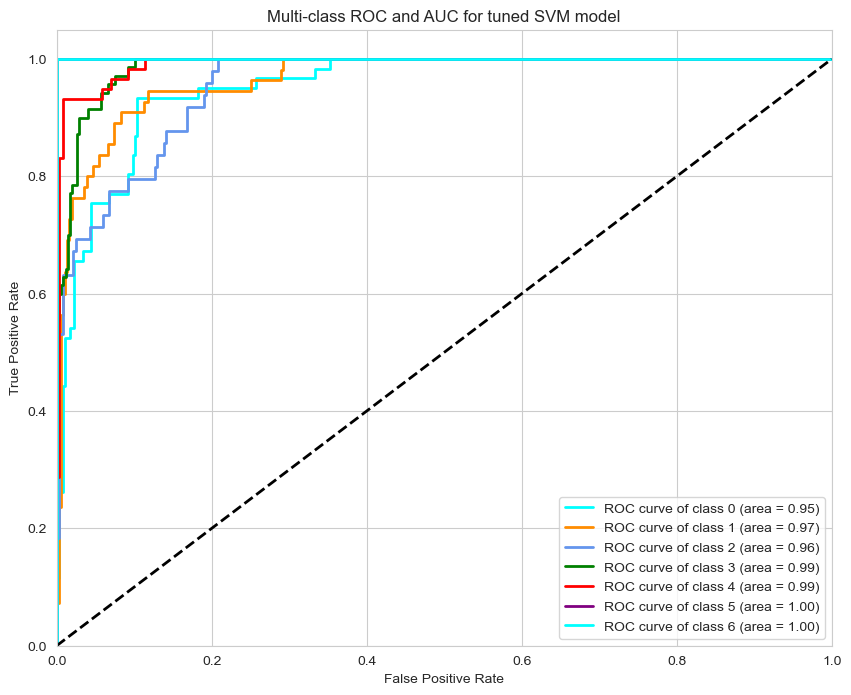

In [40]:
# ROC curve for tuned SVM model
# Binarize the output labels for multi-class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Get number of classes
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_prob = svm_grid_search.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and the micro-average
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC for tuned SVM model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Define the hyperparameters for the Decision Tree
dt_parameters = {
    'max_depth': [None, 10, 20, 30, 40, 50],  
    'min_samples_split': [2, 10, 20, 40, 80],
    'min_samples_leaf': [1, 3, 6, 12, 24],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
}

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV
dt_grid_search = GridSearchCV(dt_classifier, dt_parameters, refit=True, verbose=2, cv=3, error_score='raise')
dt_grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_dt_estimator = dt_grid_search.best_estimator_

In [24]:
# Decision Tree Accuracy Score after Hyperparameter tuning
y_pred_dt = best_dt_estimator.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_dt

0.8899521531100478

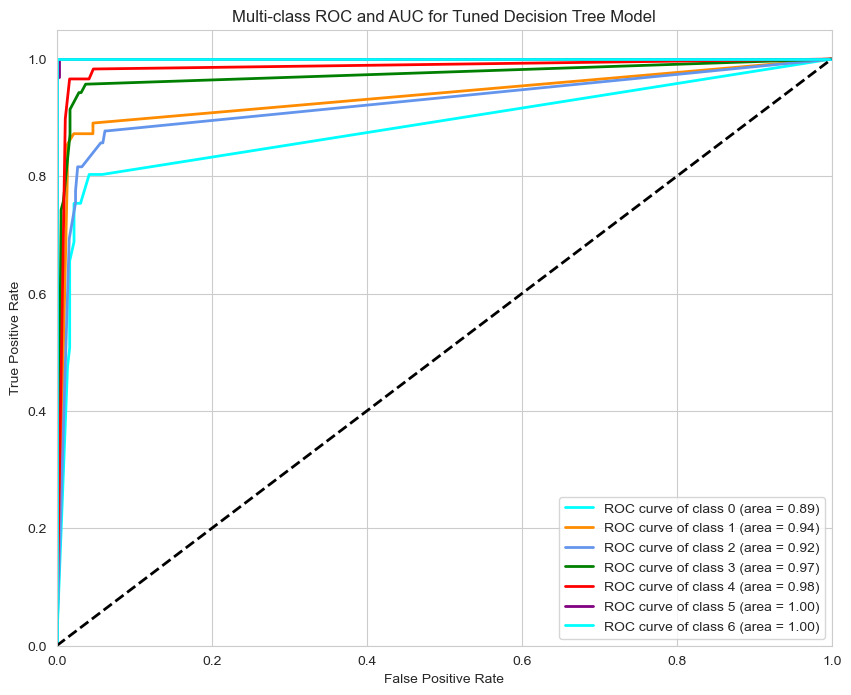

In [25]:
# ROC curve for tuned Decision Tree model
y_prob_dt = best_dt_estimator.predict_proba(X_test)

# Prepare for ROC curve and AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob_dt.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC for Tuned Decision Tree Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Hyperparameter tuning MLP Classifier
# Define the hyperparameters and their ranges to be tested
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Create an MLPClassifier instance with fixed random state
mlp = MLPClassifier(random_state=42, max_iter=1000)

# Set up RandomizedSearchCV
clf = RandomizedSearchCV(mlp, parameter_space, n_iter=10, scoring='accuracy', 
                         n_jobs=-1, cv=3, random_state=42, verbose=2)

# Fit the model to the data
clf.fit(X_train, y_train)

# Predict on the test set using the best found parameters
y_pred = clf.predict(X_test)

In [29]:
# Calculate and print the accuracy
accuracy_nn = accuracy_score(y_test, y_pred)
accuracy_nn

0.8995215311004785

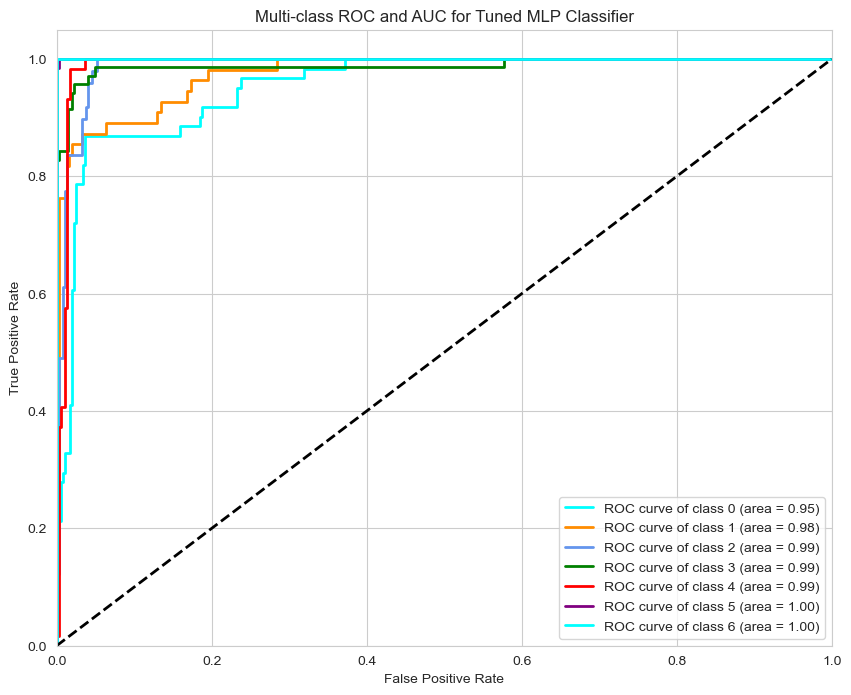

In [30]:
# ROC curve for tuned MLP Classifier model
# Binarize the output labels for multi-class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Predict probabilities for each class
y_prob_mlp = clf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC for Tuned MLP Classifier')
plt.legend(loc="lower right")
plt.show()

# Models Comparison

In [36]:
# Comparison table
# Initialize a dictionary to store metrics
model_metrics = {
    'Model': [],
    'Accuracy': [],
    'AUC/ROC Score': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}

# Function to calculate metrics and add them to the dictionary
def calculate_metrics(y_true, y_pred, y_prob, model_name):
    model_metrics['Model'].append(model_name)
    model_metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
    model_metrics['AUC/ROC Score'].append(roc_auc_score(y_true, y_prob, multi_class='ovr'))
    model_metrics['F1 Score'].append(f1_score(y_true, y_pred, average='weighted'))
    model_metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
    model_metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))

# Calculating metrics for each model and adding them to the dictionary
calculate_metrics(y_test, y_pred_grid_svm, y_prob_svm, 'SVM')
calculate_metrics(y_test, y_pred_dt, best_dt_estimator.predict_proba(X_test), 'Decision Tree')
calculate_metrics(y_test, y_pred, clf.predict_proba(X_test), 'MLP Classifier')

# Creating a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(model_metrics)

print(metrics_df)

            Model  Accuracy  AUC/ROC Score  F1 Score  Precision    Recall
0             SVM  0.870813       0.979497  0.870232   0.870511  0.870813
1   Decision Tree  0.889952       0.957264  0.889608   0.890148  0.889952
2  MLP Classifier  0.899522       0.985554  0.898927   0.899113  0.899522
